# BoT-IoT Model Generation | CNN-B
Training and generation of the CNN-B model with BoT-IoT dataset

In [1]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import keras

from keras import datasets, layers, models
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.layers import Dense
# Importing from standalone Keras
from keras.callbacks import EarlyStopping  # Keras callbacks
from keras.layers import Dense  # Keras layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

2025-03-19 14:07:23.836762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 14:07:23.843555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 14:07:23.852451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 14:07:23.854922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 14:07:23.861315: I tensorflow/core/platform/cpu_feature_guar

## BoT-IoT Model

In [2]:
# Load the BoT-IoT Dataset
data = pd.read_csv('../datasets/BoT-IoT.csv', low_memory=False)

In [3]:
data.category.value_counts()

category
DDoS              2000000
DoS               2000000
Reconnaissance    1821639
Normal               9543
Theft                1587
Name: count, dtype: int64

In [4]:
# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='igmp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

In [5]:
data.shape[0]

5802311

In [6]:
# Extracting dataset labels
data_labels=data[['attack']]

# Select interested data features
data_features=data[['proto','saddr','sport','daddr','dport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)

In [7]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(".")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(":")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(".")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(":")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dport'] = data_features['dport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dport'] = data_features['dport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dport'] = data_features['dport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['saddr'] = data_features['saddr'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['daddr'] = data_features['daddr'].astype(int)
data_features['dport'] = data_features['dport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['attack']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

In [8]:
data_features.shape

(5802311, 24, 1, 1)

In [9]:
# Use GPU 0 explicitly for model building
with tf.device('/GPU:0'):  # Use GPU 0    
    # CNN-B model building and definition
    input_shape = (24,1,1)
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(Dense(444, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Model summary
    model.summary()

I0000 00:00:1742371695.838784 2094464 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742371695.838917 2094464 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742371695.862090 2094464 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742371695.862265 2094464 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 444)            │       682,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,214 (2.69 MB)

 Trainable params: 704,214 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Early Stopping

filepath = '../models/tmp/BoT-IoT_CNN_Detection.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 2 # Stop after 2 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

# Train-test Split 75% TRAIN - 25% TEST
x_train, x_test, y_train, y_test = train_test_split(data_features, data_labels, train_size=0.75, shuffle=True)

In [13]:
from keras.callbacks import ModelCheckpoint
# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath,             # Path to save the model
    monitor='val_loss',          # Metric to monitor
    save_best_only=True,         # Save only the best model
    mode='min',                  # Mode can be 'min', 'max', or 'auto'
    verbose=1                   # Verbosity mode, 1 = progress messages
)

In [14]:
#Configure model training
with tf.device('/GPU:0'):  # Use GPU 0    

    adam=tf.keras.optimizers.Adam(learning_rate=5e-4)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        x_train, 
        y_train, 
        validation_data=(x_test, y_test), 
        epochs=25, 
        batch_size=2048, 
        callbacks=[model_checkpoint]  # Add the ModelCheckpoint here
    )

Epoch 1/25


I0000 00:00:1742371918.513993 2096656 service.cc:146] XLA service 0x785de00179e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742371918.514012 2096656 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1742371918.514013 2096656 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-19 14:11:58.529217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-19 14:11:58.590133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-03-19 14:11:59.295266: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 2872 bytes spill stores, 2712 bytes spill loads

2025-03-19 14:11:59.375797: 

  62/2125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9961 - loss: 0.3170

I0000 00:00:1742371921.207362 2096656 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2109/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0245

2025-03-19 14:12:07.453536: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 64 bytes spill stores, 64 bytes spill loads

2025-03-19 14:12:07.510709: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 548.48MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 14:12:07.510734: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 962.23MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 14:12:07.542908: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to alloc

2125/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0244

2025-03-19 14:12:09.282754: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 628.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 14:12:09.282777: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 0.00035, saving model to ../models/tmp/BoT-IoT_CNN_Detection.keras
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9993 - loss: 0.0244 - val_accuracy: 0.9999 - val_loss: 3.4722e-04
Epoch 2/25
2106/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 3.0795e-04
Epoch 2: val_loss improved from 0.00035 to 0.00016, saving model to ../models/tmp/BoT-IoT_CNN_Detection.keras
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9999 - loss: 3.0756e-04 - val_accuracy: 1.0000 - val_loss: 1.6116e-04
Epoch 3/25
2120/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.8708e-04
Epoch 3: val_loss improved from 0.00016 to 0.00012, saving model to ../models/tmp/BoT-IoT_CNN_Detection.keras
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.8712e-04 - val_accuracy: 1.0000 - val_loss: 1.1791e-04
Epoch 4/25
2110/2125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5424e-04
Epoch 4: val_loss i

In [15]:
model = tf.keras.models.load_model(filepath)

In [16]:
#Evaluate the model
results = model.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [1.3392624168773182e-05, 0.9999944567680359]


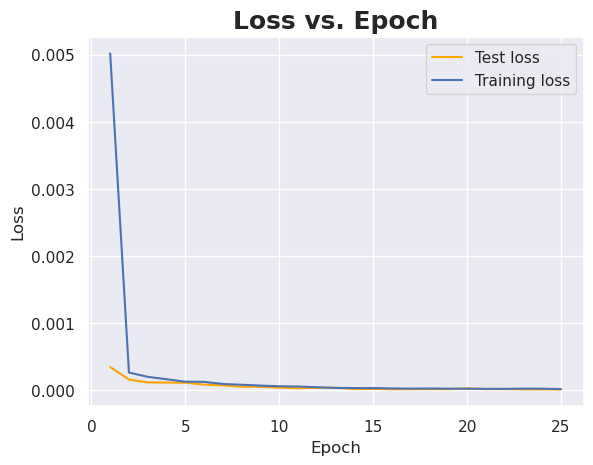

In [17]:
# summarize history for loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

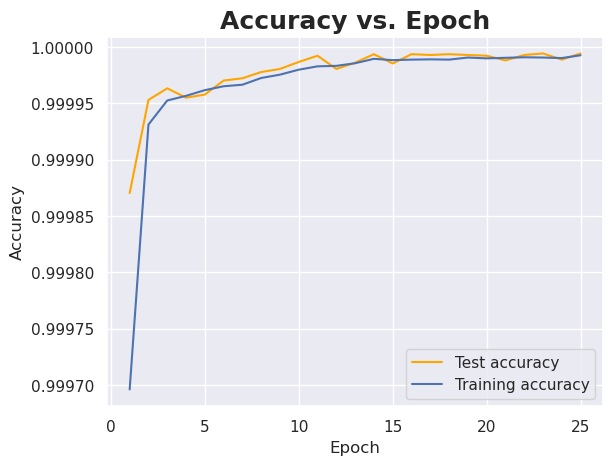

In [18]:
# summarize history for accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

45331/45331 ━━━━━━━━━━━━━━━━━━━━ 18s 380us/step


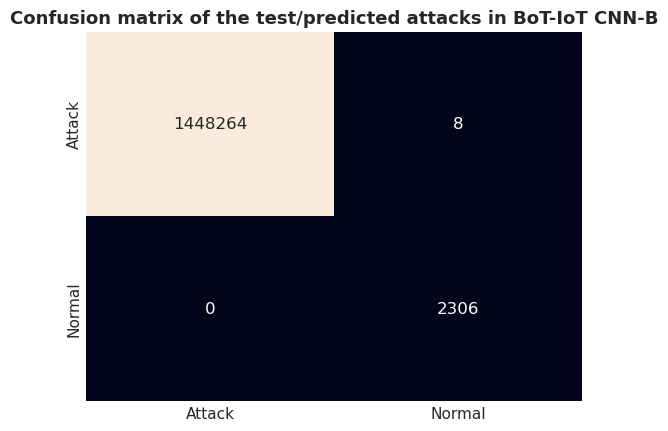

In [ ]:
with tf.device('/GPU:0'):  # Use GPU 0    
    
    # Prediction
    predicted = model.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1) 
    y_test=y_test.to_numpy()
    y_check = np.argmax(y_test, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    # Plotting Confusion Matrix
    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks in BoT-IoT CNN-B', weight='bold', fontsize=13)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

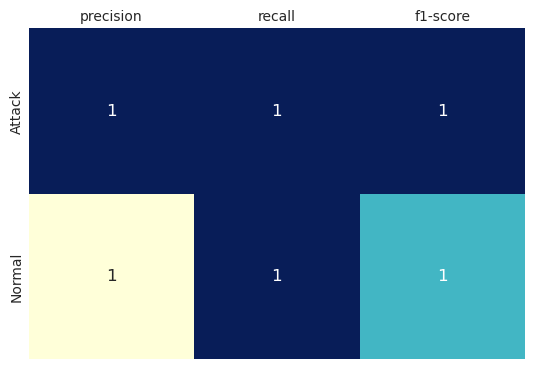

In [20]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names=['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, cmap="YlGnBu", square=True, cbar=False, annot=True)
plt.show()

In [21]:
class_rep

{'Attack': {'precision': 1.0,
  'recall': 0.999994476175746,
  'f1-score': 0.9999972380802448,
  'support': 1448272.0},
 'Normal': {'precision': 0.996542783059637,
  'recall': 1.0,
  'f1-score': 0.9982683982683983,
  'support': 2306.0},
 'accuracy': 0.9999944849570309,
 'macro avg': {'precision': 0.9982713915298185,
  'recall': 0.999997238087873,
  'f1-score': 0.9991328181743215,
  'support': 1450578.0},
 'weighted avg': {'precision': 0.999994504023731,
  'recall': 0.9999944849570309,
  'f1-score': 0.9999944897243437,
  'support': 1450578.0}}